# 胶东半岛大气环境数据分析


## 一、数据来源

从心知天气网获取胶东半岛沿海及内陆10个城市的过去24小时历史天气和大气污染物数据（10个城市分别是，东营、潍坊、滨州、淄博、济南、莱州、招远、威海、蓬莱、烟台），该网站可以通过Restful风格url获取json格式数据。

## 二、分析目的

分析沿海城市和内陆城市的气象和大气环境是否随着离海距离的变化而受到影响，是否海滨城市更适合避暑。

## 三、数据分析

In [245]:
import pandas as pd
import numpy as np
from io import StringIO
from urllib import request
import json
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**从网站获取10个城市的空气质量数据**

In [147]:
url_dongying = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=dongying&language=zh-Hans&scope=city'
url_weifang = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=weifang&language=zh-Hans&scope=city'
url_binzhou = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=binzhou&language=zh-Hans&scope=city'
url_zibo = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=zibo&language=zh-Hans&scope=city'
url_jinan = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=jinan&language=zh-Hans&scope=city'
url_laizhou = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=shandong%20laizhou&language=zh-Hans&scope=city'
url_zhaoyuan = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=shandong%20zhaoyuan&language=zh-Hans&scope=city'
url_weihai = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=weihai&language=zh-Hans&scope=city'
url_penglai = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=penglai&language=zh-Hans&scope=city'
url_yantai = 'https://api.seniverse.com/v3/air/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=yantai&language=zh-Hans&scope=city'

In [148]:
url_dict = {'dongying' : url_dongying, 'weifang' : url_weifang, 'binzhou' : url_binzhou, 'zibo' : url_zibo, 'jinan' : url_jinan, 'laizhou' : url_laizhou,
            'zhaoyuan' : url_zhaoyuan, 'weihai' : url_weihai, 'penglai' : url_penglai, 'yantai' : url_yantai}

In [149]:
#把各个城市的dict，整理成DataFrame接收的dict
def gen_table(list2):
    data_dict = {}
    for i, value in enumerate(list2):
        data_dict[i] = value['city']
    return data_dict

In [150]:
def read_html(url_dict):
    df_list = []
    for location, url in list(url_dict.items()):
        s = request.urlopen(url).read().decode('utf8')#从网上把数据读成json字符串
        data_dict = json.loads(s)#把json字符串转换成dict
        data = data_dict['results'][0]['hourly_history']#调出监测值
        data_dict = gen_table(data)#自建方法，把dict转成DataFrame可接收形式
        data_df = pd.DataFrame(data_dict).T
        data_df['location'] = location#加入地理标签
        df_list.append(data_df) #整理成各个城市DataFrame的列表
    return df_list

In [151]:
list_p = read_html(url_dict) #警告： 这步超慢，网络操作

In [152]:
all_p = pd.concat(list_p) #把各个城市的列表沿0轴拼接

In [283]:
distance = pd.read_csv('D:/python/practise/sample/weather/distance.csv', header = None)
distance.sort_values(by = 1)

,0,1
9,yantai,1.9
8,penglai,2.0
7,weihai,2.4
5,laizhou,8.3
0,dongying,16.6
6,zhaoyuan,24.7
1,weifang,49.1
2,binzhou,80.5
3,zibo,99.2
4,jinan,172.5


In [154]:
all_p = pd.merge(all_p, distance, left_on = 'location', right_on = 0)
all_p = all_p.drop(0, axis = 1).rename(columns = {1 : 'distance'})

In [155]:
time = all_p['last_update'].astype(str)
time = time.str[:19]
time = time.str.replace('T', ' ')
time = time.map(lambda x : parse(x))
time = time.dt.strftime('%H-%m/%d')
all_p['last_update'] = time

**大气环境质量数据表**

In [156]:
all_p.head()

,aqi,co,last_update,no2,o3,pm10,pm25,quality,so2,location,distance
0,53,0.625,13-08/09,7,143,56,35,良,9,dongying,16.6
1,55,0.700,12-08/09,11,127,59,33,良,11,dongying,16.6
2,52,0.750,11-08/09,16,81,53,30,良,14,dongying,16.6
3,49,0.750,10-08/09,18,56,49,28,优,17,dongying,16.6
4,48,0.750,09-08/09,17,38,48,25,优,17,dongying,16.6


In [157]:
all_p['aqi'] = all_p['aqi'].astype(int)
all_p['pm10'] = all_p['pm10'].astype(int)

**从网站获取10个城市气象数据**

In [159]:
url_dongying_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=dongying&language=zh-Hans&unit=c'
url_weifang_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=weifang&language=zh-Hans&unit=c'
url_binzhou_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=binzhou&language=zh-Hans&unit=c'
url_zibo_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=zibo&language=zh-Hans&unit=c'
url_jinan_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=jinan&language=zh-Hans&unit=c'
url_laizhou_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=shandong%20laizhou&language=zh-Hans&unit=c'
url_zhaoyuan_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=shandong%20zhaoyuan&language=zh-Hans&unit=c'
url_weihai_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=weihai&language=zh-Hans&unit=c'
url_penglai_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=penglai&language=zh-Hans&unit=c'
url_yantai_w = 'https://api.seniverse.com/v3/weather/hourly_history.json?key=Sz6GmmiQ6SAjYTKbc&location=yantai&language=zh-Hans&unit=c'

In [160]:
url_dict_w = {'dongying' : url_dongying_w, 'weifang' : url_weifang_w, 'binzhou' : url_binzhou_w, 'zibo' : url_zibo_w, 'jinan' : url_jinan_w, 'laizhou' : url_laizhou_w,
            'zhaoyuan' : url_zhaoyuan_w, 'weihai' : url_weihai_w, 'penglai' : url_penglai_w, 'yantai' : url_yantai_w}

In [161]:
def gen_table_w(list1):
    data_dict = {}
    for i, value in enumerate(list1):
        data_dict[i] = value
    return data_dict

In [162]:
def read_html_w(url_dict2):
    df_list = []
    for location, url in list(url_dict2.items()):
        s = request.urlopen(url).read().decode('utf8')#从网上把数据读成json字符串
        data_dict = json.loads(s)#把json字符串转换成dict
        data = data_dict['results'][0]['hourly_history']#调出监测值
        data_dict = gen_table_w(data)#自建方法，把dict转成DataFrame可接收形式
        data_df = pd.DataFrame(data_dict).T
        data_df['location'] = location#加入地理标签
        df_list.append(data_df) #整理成各个城市DataFrame的列表
    return df_list

In [163]:
list_w = read_html_w(url_dict_w) #警告： 这步超慢，网络操作

In [164]:
all_w = pd.concat(list_w) #把各个城市的列表沿0轴拼接

In [165]:
time = all_w['last_update'].astype(str)
time = time.str[:19]
time = time.str.replace('T', ' ')
time = time.map(lambda x : parse(x))
time = time.dt.strftime('%H-%m/%d')
all_w['last_update'] = time

**气象数据表**

In [281]:
all_w.head()

,clouds,code,dew_point,feels_like,humidity,last_update,pressure,temperature,text,visibility,wind_direction,wind_direction_degree,wind_scale,wind_speed,location
0,50,4,,33,60,14-08/09,1003,33,多云,12.2,南,183,3,14.4,dongying
1,90,9,,33,66,13-08/09,1003,33,阴,8.0,南,158,2,11.52,dongying
2,90,9,,32,70,12-08/09,1004,32,阴,7.9,东南,149,3,12.6,dongying
3,90,9,,31,72,11-08/09,1004,31,阴,7.0,东南,136,2,11.16,dongying
4,90,9,,30,78,10-08/09,1004,30,阴,6.7,东南,153,3,13.32,dongying


In [166]:
all_p1 = all_p.groupby('location').apply(lambda x : x[:-1])

In [167]:
all_w1 = all_w.groupby('location').apply(lambda x : x[1:])

In [168]:
all_p1.shape

(230, 11)

In [169]:
all_w1.shape

(230, 15)

In [170]:
all_p1['index'] = range(230)
all_w1['index'] = range(230)

In [171]:
mix = pd.merge(all_p1, all_w1, on = 'index')

In [172]:
pd.set_option('max_columns', 27)
mix = mix.drop(['last_update_y', 'location_y', 'dew_point', 'wind_direction', 'wind_direction_degree', 'text', 'index', 'code'], axis = 1).rename(columns = {'last_update_x' : 'last_update', 'location_x' : 'location'})

**将气象和环境质量数据合并为一个表**

In [173]:
mix.head()

,aqi,co,last_update,no2,o3,pm10,pm25,quality,so2,location,distance,clouds,feels_like,humidity,pressure,temperature,visibility,wind_scale,wind_speed
0,58,1.200,13-08/09,13,163,57,41,良,6,binzhou,80.5,50,33,63,1002,33,9.2,2,5.76
1,65,1.267,12-08/09,17,167,63,47,良,8,binzhou,80.5,50,32,65,1003,33,8.3,2,8.28
2,64,1.500,11-08/09,22,150,65,46,良,12,binzhou,80.5,50,32,66,1003,32,5.8,2,6.12
3,64,1.667,10-08/09,32,93,69,46,良,14,binzhou,80.5,50,31,70,1003,31,5.2,3,14.76
4,64,1.367,09-08/09,43,48,77,44,良,29,binzhou,80.5,50,30,79,1004,30,5.5,2,6.12


**进行数据整理**

In [174]:
mix['wind_speed'] = mix['wind_speed'].astype(float)
mix['co'] = mix['co'].astype(float)
mix['pm25'] = mix['pm25'].astype(int)
mix['no2'] = mix['no2'].astype(int)
mix['o3'] = mix['o3'].astype(int)
mix['pm10'] = mix['pm10'].astype(int)
mix['so2'] = mix['so2'].astype(int)
mix['clouds'] = mix['clouds'].astype(int)
mix['feels_like'] = mix['feels_like'].astype(int)
mix['humidity'] = mix['humidity'].astype(int)
mix['pressure'] = mix['pressure'].astype(int)
mix['temperature'] = mix['temperature'].astype(int)
mix['wind_scale'] = mix['wind_scale'].astype(int)
mix['visibility'] = mix['visibility'].astype(float)


In [175]:
def with_distance(number_df, y_str, ax):
    df = number_df.groupby('location')[y_str,'distance'].mean().sort_values(by = 'distance')
    ax.scatter(x = df['distance'].values, y = df[y_str].values, color = 'purple')
    ax.set_title(y_str)

In [188]:
def plot_distance():
    number_df = mix.drop(['last_update', 'quality'], axis = 1)
    fig, ax = plt.subplots(4, 4, figsize = (16, 16))
    compare_list = list(number_df.columns)
    compare_list.remove('location')
    compare_list.remove('distance')
    k = 0
    for i in range(4):
        for j in range(4):
            with_distance(number_df, compare_list[k], ax[i ,j])
            if k < len(compare_list) - 1:
                k += 1
            else:
                break
    plt.xlabel('distance')

### 各个城市随着离岸距离的变化，各项污染物浓度和气象指标的变化

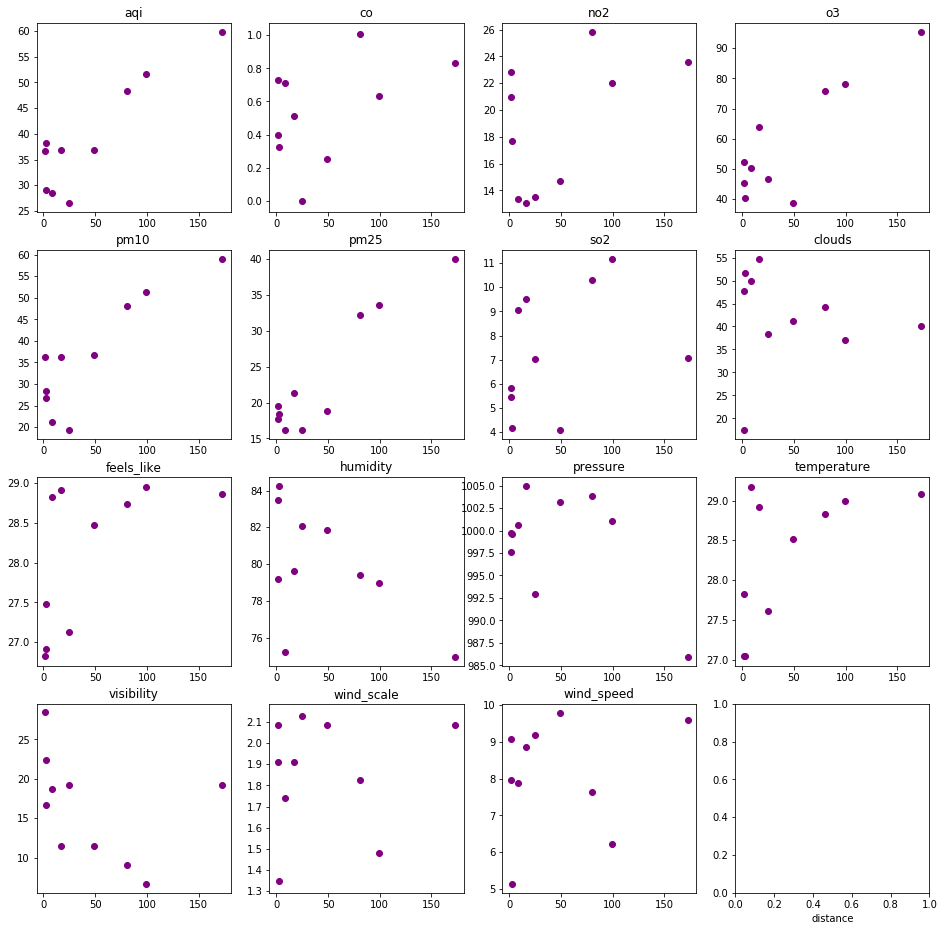

In [189]:
plot_distance()

**从图上可以看出：**
1. **距离与aqi/O3/PM10/PM2.5/temperature这五个指标呈正相关关系**
2. **距离与humidity/visibility这两个指标呈负相关关系**
3. **另外，每个与距离呈线性关系的指标中，前4个值与后六个值相关性有明显区别，其中，温度这一项比较明显，其次是湿度**<br>

**再分别计算出各指标与距离的线性相关系数**

In [192]:
mix.corrwith(mix.distance)

aqi            0.725821
co             0.412913
no2            0.252504
o3             0.383070
pm10           0.637895
pm25           0.772149
so2            0.209541
distance       1.000000
clouds        -0.047578
feels_like     0.213602
humidity      -0.146052
pressure      -0.501988
temperature    0.192271
visibility    -0.269121
wind_scale     0.038407
wind_speed     0.058204
dtype: float64

**从上表中看出，与距离相关性最高的是PM2.5其值为0.77**<br>
### 分别用PM2.5和温度做回归分析

In [196]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [253]:
data_pm25 = mix.groupby('location')['pm25', 'distance'].mean().sort_values(by = 'distance')
data_temp = mix.groupby('location')['temperature', 'distance'].mean().sort_values(by = 'distance')

In [269]:
data_temp_1 = data_temp[:5]
data_temp_2 = data_temp[5:]

In [270]:
y_temp_1, x_temp_1 = patsy.dmatrices('temperature~distance', data_temp_1)
y_temp_2, x_temp_2 = patsy.dmatrices('temperature~distance', data_temp_2)

In [271]:
model_temp_1 = sm.OLS(y_temp_1, x_temp_1)
result_temp_1 = model_temp_1.fit()
model_temp_2 = sm.OLS(y_temp_2, x_temp_2)
result_temp_2 = model_temp_2.fit()

In [272]:
y_temp_1_p = result_temp_1.predict(x_temp_1)
y_temp_2_p = result_temp_2.predict(x_temp_2)

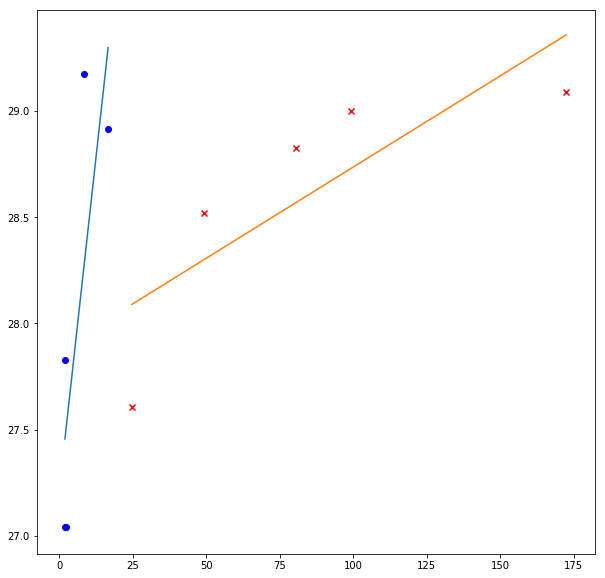

In [273]:
fig = plt.figure(figsize = (10, 10))
plt.plot(data_temp_1.distance.values, y_temp_1_p)
plt.plot(data_temp_2.distance.values, y_temp_2_p)
plt.scatter(data_temp_2.distance.values, y_temp_2, c = 'r', marker = 'x')
plt.scatter(data_temp_1.distance.values, y_temp_1, c = 'b', marker = 'o')

**从上图可以看到离海20公里以内，24小时气温平均值上升速度很快，由27度升到31度，随后增速减缓25-180公里才上升1.5度**

### 再来分析PM2.5与距离的关系

In [259]:
y_pm25, x_pm25 = patsy.dmatrices('pm25~distance', data = data_pm25)

In [260]:
model_pm25 = sm.OLS(y_pm25, x_pm25)

In [261]:
result_pm25 = model_pm25.fit()

In [262]:
y_pm25_p = result_pm25.predict(x_pm25)

Text(0, 0.5, 'PM2.5')

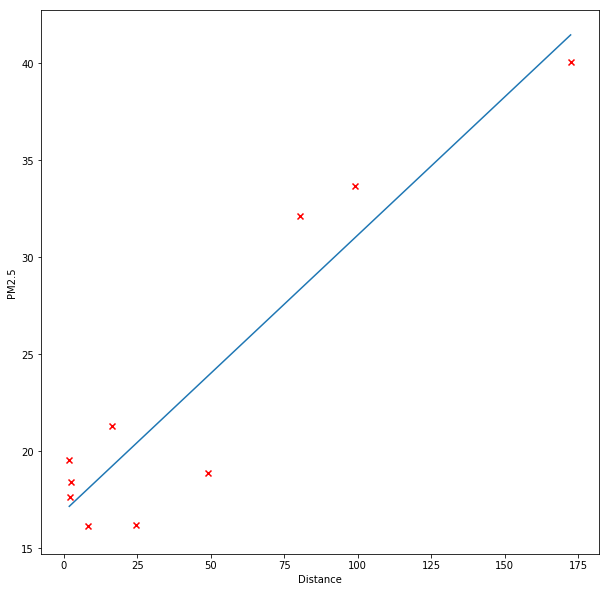

In [275]:
fig = plt.figure(figsize = (10, 10))
plt.plot(data_pm25.distance.values, y_pm25_p)
plt.scatter(data_pm25.distance.values, y_pm25, c = 'r', marker = 'x')
plt.xlabel('Distance')
plt.ylabel('PM2.5')

In [274]:
result_pm25.params

array([16.8848836 ,  0.14240526])

**由图可以看到，胶东半岛的近海区域普遍PM2.5值较低，距离超过50公里后，大约每远离1公里PM2.5值上升0.14**

### 下面就各个城市范围内，分析各大气指标之间的关系

**先看各指标之间线性关系的热力图**

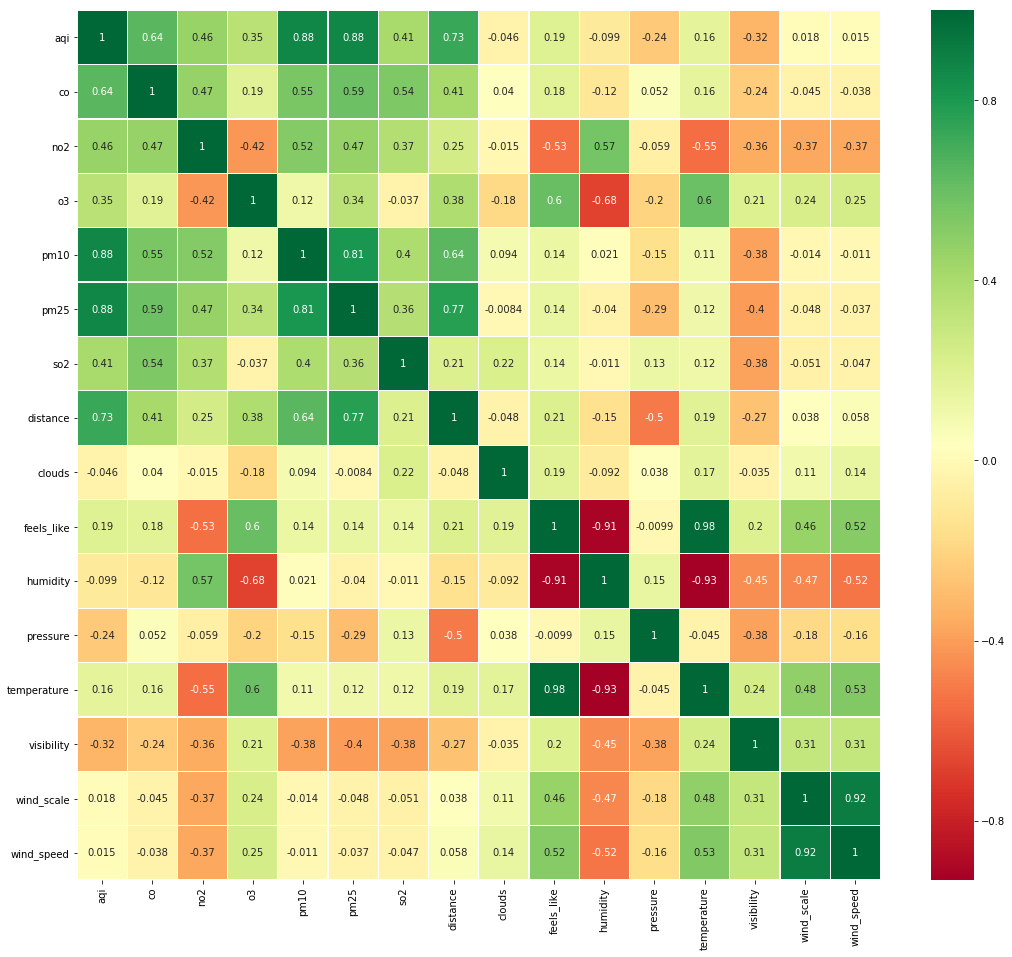

In [276]:
plt.figure(figsize = (18,16))
sns.heatmap(mix.corr(), annot = True, cmap='RdYlGn',linewidths=0.2)

**从热力图可以看出，PM2.5和aqi之间，PM2.5和PM10之间，湿度和温度，湿度和舒适感之间线性关系较强**

In [ ]:
mix.groupby('location')['pm10','distance'].mean().sort_values(by = 'distance')

In [ ]:
def plot_pic(x_str, y_str):
    fig, ax = plt.subplots(4, 3, figsize = (14, 14))
    k = 0
    group_list = list(mix.groupby('location'))  #list套GroupBy分组对象,编程元祖列表
    for i in range(4):
        for j in range(3):
            pic = group_list[k]
            name = pic[0]  #可以分别拿出分组名和组对象
            group = pic[1]
            ax[i, j].scatter(x = group[x_str].values, y = group[y_str].values, color = 'r')
            ax[i, j].set_title(name)
                        
            if k < 9:
                k += 1
            else:
                break
    plt.xlabel(x_str)
    plt.ylabel(y_str)
##        
#for name, group in list(mix.groupby('location_x')):
#    ax[i].scatter(x = group['wind_speed'].values, y = group['pm25'].values)
#    ax[i].set_title(name)
#    i += 1

**PM2.5和aqi指数之间的关系**

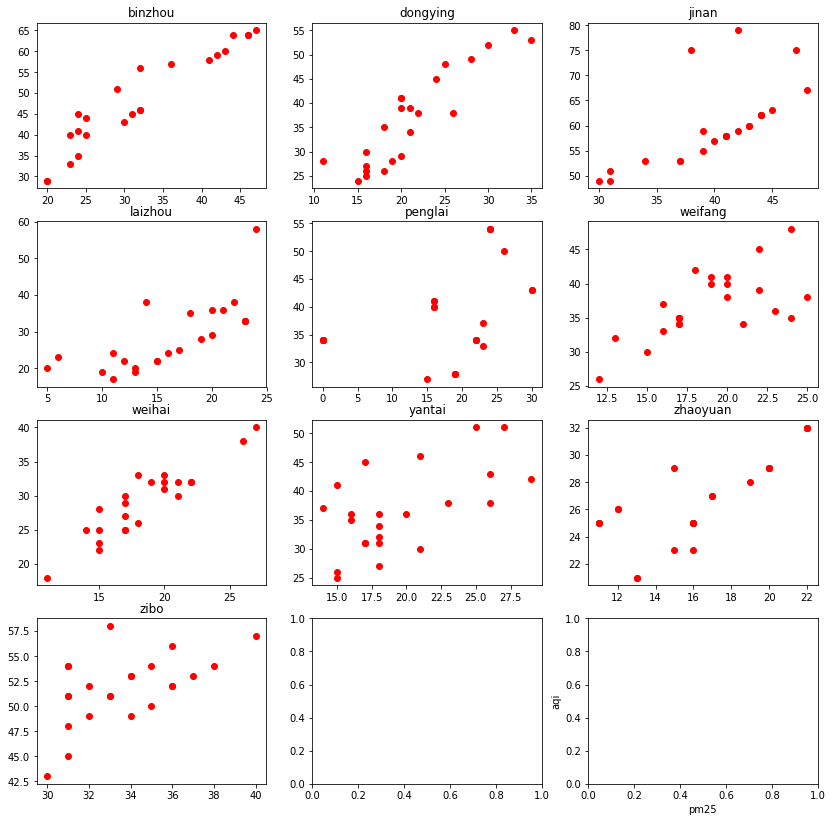

In [193]:
plot_pic('pm25','aqi')

**可以看出PM2.5和aqi指数之间存在线性关系较其他城市强，反应PM2.5是主要污染物**<br>

**以下是PM2.5和PM10的关系**

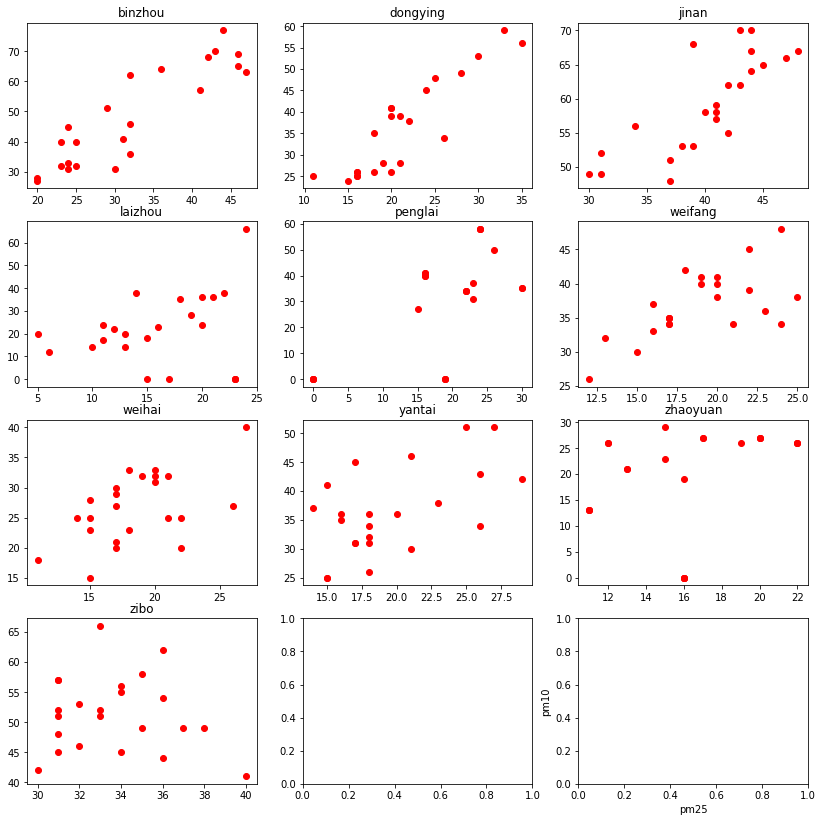

In [278]:
plot_pic('pm25','pm10')

**以下是温度和湿度的关系**

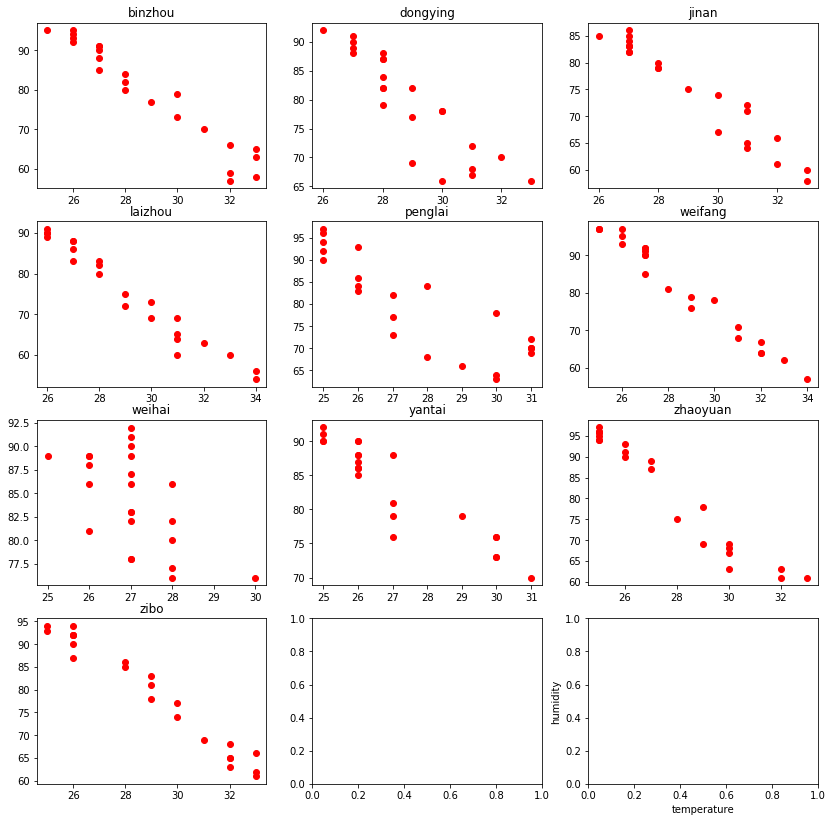

In [277]:
plot_pic('temperature','humidity')

**舒适度和湿度的关系**

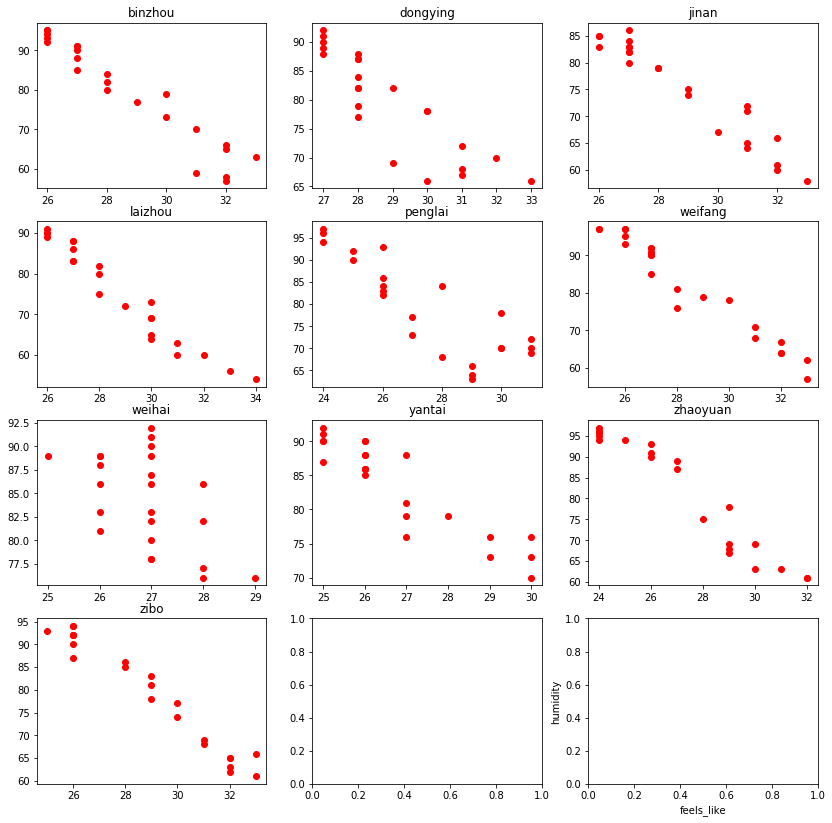

In [279]:
plot_pic('feels_like','humidity')

**从直观感觉上风速与PM2.5之间存在关系，用图形看看是否如此**

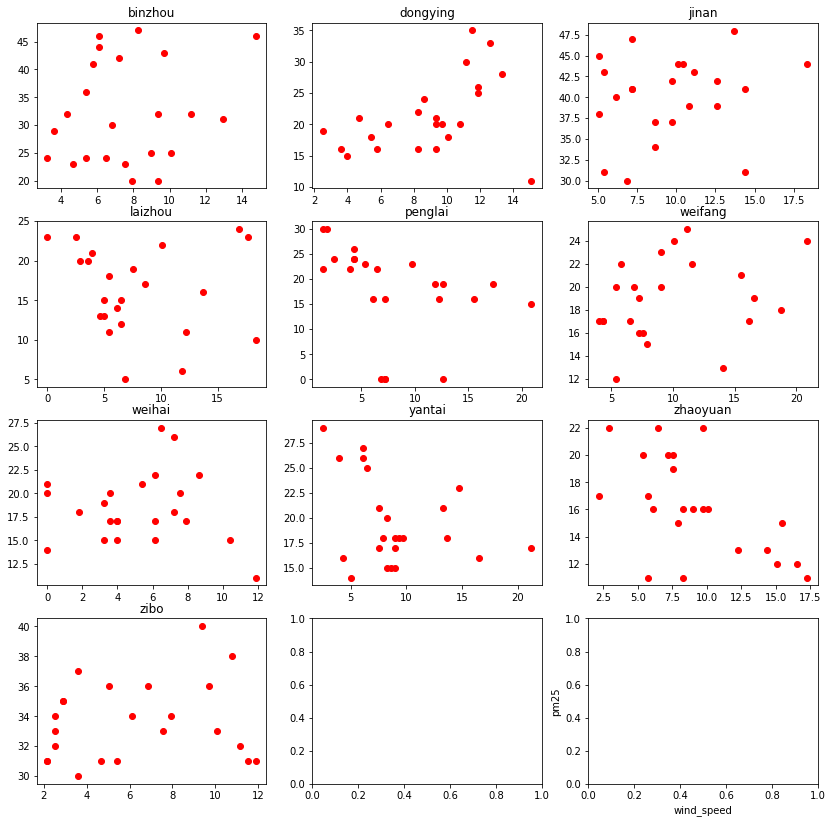

In [280]:
plot_pic('wind_speed','pm25')